In [13]:
import numpy as np
import pandas as pd
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors

In [72]:
data =  pd.read_csv('iris.data', sep=",",header = None)
data.iloc[:,0:4]

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [86]:
data_x=data.iloc[:,0:4].to_numpy()
data_y=data.iloc[:,4].to_numpy()

In [88]:
for i in range(0,data_y.shape[0]):
    if data_y[i] == 'Iris-setosa':
        data_y[i]=0
    if data_y[i] == 'Iris-versicolor':
        data_y[i]=1
    if data_y[i] == 'Iris-virginica':
        data_y[i]=2

In [89]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) # check the shapes

(120, 4) (120,) (30, 4) (30,)


In [90]:
# Helper functions

# Data Normalisation
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled

# Euclidean distance
def e_distance(x,y):
    return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
    return distance.cityblock(x,y)

# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
    winner = [0,0]
    shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
    input_data = data[t]
    for row in range(num_rows):
        for col in range(num_cols):
            distance = e_distance(som[row][col], data[t])
            if distance < shortest_distance: 
                shortest_distance = distance
                winner = [row,col]
    return winner

# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
    coefficient = 1.0 - (np.float64(step)/max_steps)
    learning_rate = coefficient*max_learning_rate
    neighbourhood_range = ceil(coefficient * max_m_dsitance)
    return learning_rate, neighbourhood_range

In [100]:
# hyperparameters
num_rows = 20
num_cols = 20
max_m_dsitance = 4
max_learning_rate = 0.5
max_steps = int(7.5*10e3)

# num_nurons = 5*np.sqrt(train_x.shape[0])
# grid_size = ceil(np.sqrt(num_nurons))
# print(grid_size)

In [101]:
#main function

train_x_norm = minmax_scaler(train_x) # normalisation

# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
    if (step+1) % 5000 == 0:
        print("Iteration: ", step+1) # print out the current iteration for every 5k
    learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

    t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    for row in range(num_rows):
        for col in range(num_cols):
            if m_distance([row,col],winner) <= neighbourhood_range:
                som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  5000
Iteration:  10000
Iteration:  15000
Iteration:  20000
Iteration:  25000
Iteration:  30000
Iteration:  35000
Iteration:  40000
Iteration:  45000
Iteration:  50000
Iteration:  55000
Iteration:  60000
Iteration:  65000
Iteration:  70000
Iteration:  75000
SOM training completed


In [102]:
# collecting labels

label_data = train_y
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
    for col in range(num_cols):
        map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
    if (t+1) % 1000 == 0:
        print("sample data: ", t+1)
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

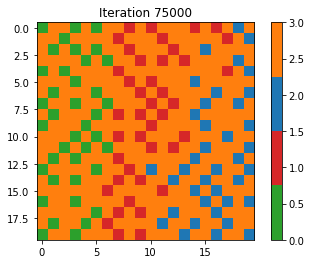

In [104]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
    for col in range(num_cols):
        label_list = map[row][col]
        if len(label_list)==0:
            label = 3
        else:
            label = max(label_list, key=label_list.count)
        label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:blue','tab:orange'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [105]:
map

array([[list([0]), list([]), list([]), list([0]), list([]), list([0]),
        list([]), list([]), list([1]), list([]), list([1]), list([]),
        list([]), list([]), list([1]), list([]), list([1]), list([]),
        list([2]), list([])],
       [list([]), list([]), list([0]), list([]), list([]), list([]),
        list([]), list([1]), list([]), list([]), list([]), list([1]),
        list([]), list([]), list([]), list([]), list([]), list([1]),
        list([]), list([2])],
       [list([]), list([0]), list([]), list([0]), list([]), list([0]),
        list([]), list([]), list([1]), list([]), list([]), list([]),
        list([1]), list([]), list([]), list([2]), list([]), list([]),
        list([]), list([])],
       [list([]), list([]), list([]), list([]), list([0, 0]), list([]),
        list([0]), list([]), list([]), list([1]), list([]), list([1]),
        list([]), list([1]), list([]), list([]), list([]), list([]),
        list([2]), list([])],
       [list([0]), list([]), list([0]), 